# EDA

## Import Data and Libraries

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Viewing Images

In this project, we are working with images of chest X-rays which we are classifying into two categories: pneumonia or normal. First, let's look at the difference between these.

#### Normal:
<table style="border-collapse: collapse;">
    <tr>
        <td style="border: none;"><img src="Images/normal1.jpeg" alt="normal1" width="450px"/></td>
        <td style="border: none;"><img src="Images/normal2.jpeg" alt="normal2" width="400px"/></td>
        <td style="border: none;"><img src="Images/normal3.jpeg" alt="normal3" width="400px"/></td>
    </tr>
</table>

#### Pneumonia:
<table style="border-collapse: collapse;">
    <tr>
        <td style="border: none;"><img src="Images/pneumonia1" alt="pneumonia1" width="450px"/></td>
        <td style="border: none;"><img src="Images/pneumonia2" alt="pneumonia2" width="400px"/></td>
        <td style="border: none;"><img src="Images/pneumonia3" alt="pneumonia3" width="400px"/></td>
    </tr>
</table>

From <a href="https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia">Radiology.org</a>: <br> _Pneumonia is an infection that causes inflammation in one or both of the lungs. It can be caused by a virus, bacteria, fungi or other germs. The infection is usually acquired when a person breathes in air carrying germs._

When radiologists look at these images, they look for white spots called infiltrates that identify an infection, as well as abscesses or fluids that could be caused by pneumonia. We find it a bit difficult to tell the difference between these due to not being trained radiologists, but we can definitely say some x-rays (such as the leftmost pneumonia picture above) look more "cloudy" than others.

## Class Distribution

Before we start modeling, we want to check for class imbalance. Our data is split into 3 directories, each holding the images needed for our test, train, and validation sets. We'll add up the number of files in these directories to get the count of data points in each class.

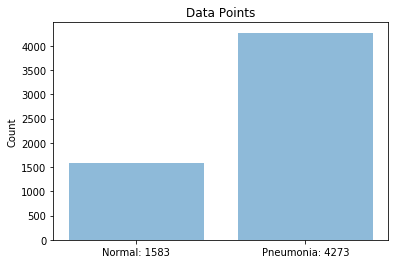

In [20]:
n_count = len(os.listdir('chest_xray/test/NORMAL')) + len(os.listdir('chest_xray/train/NORMAL')) + len(os.listdir('chest_xray/val/NORMAL'))
p_count = len(os.listdir('chest_xray/test/PNEUMONIA')) + len(os.listdir('chest_xray/train/PNEUMONIA')) + len(os.listdir('chest_xray/val/PNEUMONIA'))

objects = (f'Normal: {n_count}', f'Pneumonia: {p_count}')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [n_count,p_count], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Data Points')

plt.show()

We can see we have a 27:73 split. This isn't a huge imbalance, but definitely something to keep in mind when evaluating our models, as our null accuracy is 73%. This is the accuracy we could achieve by always predicting the most frequent class.